By [Kevin Michalewicz](https://kevinmichalewicz.com) and [Martin Millon](https://martin-millon.gitlab.io) on June 2023.

This notebook details how to generate a narrow Point Spread Function (PSF) using stars measured by the MPG/ESO 2.2m telescope and its WFI camera.

## Principle and formulation

Let $t(\mathbf{x})$ be a full Point Spread Function (PSF). The main idea is to produce a function $s(\mathbf{x})$ such that the PSF of the deconvolved image is $r(\mathbf{x})$: a Gaussian function with a FWHM of 2 pixels, instead of a Delta distribution. This can be written as

$$t(\mathbf{x})=s(\mathbf{x})*r(\mathbf{x})$$

One can propose as well that

$$s(\mathbf{x})=m(\mathbf{x})+h(\mathbf{x})$$

* $m(\mathbf{x})$ is a Moffat function
* $h(\mathbf{x})$ is a grid of pixels

It is necessary to extract $M$ observation stamps $t_k(\mathbf{x})$ and to minimize the following objective function

$$\mathcal{S}=\sum_{k=1}^{M}\left\lVert \frac{t_k(\mathbf{x})-\Big( s(\mathbf{x})*a_kr(\mathbf{x}-\mathbf{c}_k)\Big)^\downarrow}{\sigma_k}\right\rVert_2^2+\lambda_{\text{scales}}\Big\lVert\phi_{\text{scales}}\big(s(\mathbf{x})\big)\Big\rVert_1+\lambda_{\text{hf}}\Big\lVert\phi_{\text{hf}}\big(s(\mathbf{x})\big)\Big\rVert_1$$

* $\phi(\cdot)$ is the Starlet transform operator
* $\downarrow$ performs the subsampling operation
* $\sigma_k$ is the noise level at each pixel for the $k$-th stamp 
* $\mathbf{c}_k = \begin{bmatrix}c_{x_k} & c_{y_k}\end{bmatrix}^\text{T}$ is the position of the point source in the $k$-th stamp 
* $a_k$ is the amplitude of the corresponding Gaussian
* $\lambda_{\text{hf}}$ is the Lagrange parameter that weights the presence of the highest frequencies of the grid of pixels $b(\mathbf{x})$
* $\lambda_{\text{scales}}$ is the Lagrange parameter that weights all other scales (except the coarsest one)

*Fact:* given $M$ $(\frac{\sqrt{N}}{D}\times\frac{\sqrt{N}}{D})$ input stamps, $N+M+2$ parameters are needed to construct $s$ (a downsampling factor $D$ is assumed here).

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

from copy import deepcopy
from matplotlib import colors
import pyregion

from starred.psf.psf import PSF, load_PSF_model
from starred.psf.loss import Loss
from starred.optim.optimization import Optimizer
from starred.psf.parameters import ParametersPSF
from starred.plots import plot_function as pltf
from starred.utils.noise_utils import propagate_noise

from astropy.io import fits

## Parameters of the model 

The most important parameters are `lambda_hf` and `lambda_scales`. They control the regularisation strength of the first starlet scale (i.e. the highest frequencies) for `lambda_hf` and of all other starlet scales (lower frequencies) for `lambda_scales`. They are given in units of the noise level. `lambda_hf` = `lambda_scales` = 3 means that we will suppress all starlet coefficients that are below 3 standard deviations from the noise level. In most cases, you should leave those parameters between 1 and 3 to obtain a $\chi^2$ close to one. Increasing `lambda_scales` and `lambda_hf` will increase the $\chi^2$ of the fit. 

This requires that your noise map, including the Poisson noise, be __correctly estimated__. Remember that the Poisson noise corresponds to $\sqrt(D)$ if your data are in electrons! The data in this notebook are in ADU, so we convert them to electrons to estimate the noise maps.

The other important parameter is `subsampling_factor`, which controls the resolution of your reconstructed PSF. `subsampling_factor` = 2 will produce a subsampled PSF by a factor of 2, compared to the original image. 

In [2]:
# Parameters
subsampling_factor = 2

# The data are in ADU, so we need to convert in e- to properly estimate the noise
gain = 2. # WFI camera inverse gain in e-/ADU
t_exp = 1. # in seconds, as the image is in ADU

lambda_scales = 3. 
lambda_hf = 3.
lambda_positivity = 0. #penalising term if the full psf have negative pixels. Leave it to 0. in most cases to save computationnal time.
include_moffat = True #Include a Moffat in the PSF. This helps the optimiser to converge to the solution. Default : True 
regularize_full_psf = False #If True, regularise [m(x)+b(x)]. Regularise only the b(x) if False. Default: False
elliptical = True # if you want to fit ellitpical moffat or simply circular 
refine_noise_maps_from_model = True
method_noise = 'MC' #Default : 'MC' 

optim_method = 'Newton-CG'
data_path = 'data/1_observations'
convolution_method = 'scipy' #choose 'fft' for a faster implementation on CPU if your version of jax is < 0.4.9, 'scipy' is the fastest on the most recent version of jax


### Retrieving the data

In [3]:
# Data 
file_paths = sorted(glob.glob(os.path.join(data_path, '*.npy')))
new_vignets_data = np.array([np.load(f) for f in file_paths]) * t_exp * gain
N = len(file_paths) # number of stars
image_size = np.shape(new_vignets_data)[1] # data dimensions
image_size_up = image_size * subsampling_factor 

### Applying masks

Masks are rarely necessary but can be used to remove nearby galaxies or companion stars that can pertub the fit of your PSF stars. You can create masks as region in DS9 and save them as `mask_STAR_ID.reg`. Save your region in "image" mode or provide the header to `pyregion`.

In [4]:
# This is rarely necessary, but you can mask some pixel of your data. You can provide a mask as a numpy array or provide .reg file generated by DS9
# DS9 Region documentation : http://www.ugastro.berkeley.edu/leuschner/old_site/ccd/ccddocs/region.html

masks = np.ones((N, image_size, image_size))
for i in range(N):
    possiblemaskfilepath = os.path.join(data_path, 'mask_%s.reg'%str(i))
    if os.path.exists(possiblemaskfilepath):
        print('Using mask %s for star %i !'%(possiblemaskfilepath, i))
        r = pyregion.open(possiblemaskfilepath)
        masks[i, :, :] =  1 - r.get_mask(shape=(image_size, image_size)).astype(float)

Using mask data/1_observations/mask_2.reg for star 2 !


## Noise map estimation 
Now that our data are converted to e-, we can estimate the noise level by adding the bacground noise (measured in some empty part of the cutouts) and the Poisson noise.

The data are also normalise to facilitate the convergence of the `adabelief` optimiser, which works better with small numbers.

In [5]:
# Noise map estimation
sigma_2 = np.zeros((N, image_size, image_size))
sigma_sky_2 = np.array([np.std(new_vignets_data[i,int(0.9*image_size):,int(0.9*image_size):]) for i in range(N)]) ** 2
for i in range(N):
    sigma_2[i,:,:] = sigma_sky_2[i] + new_vignets_data[i,:,:].clip(min=0)

#Renormalise your data and the noise maps by the max of the first image. Works better when using adabelief
norm = new_vignets_data[0].max() / 100.
new_vignets_data /= norm
sigma_2 /= norm**2 #Note that this is not equivalent to scale the data first, and then compute the Poisson noise. Poisson noise needs to be computed before rescaling.

## Data visualisation

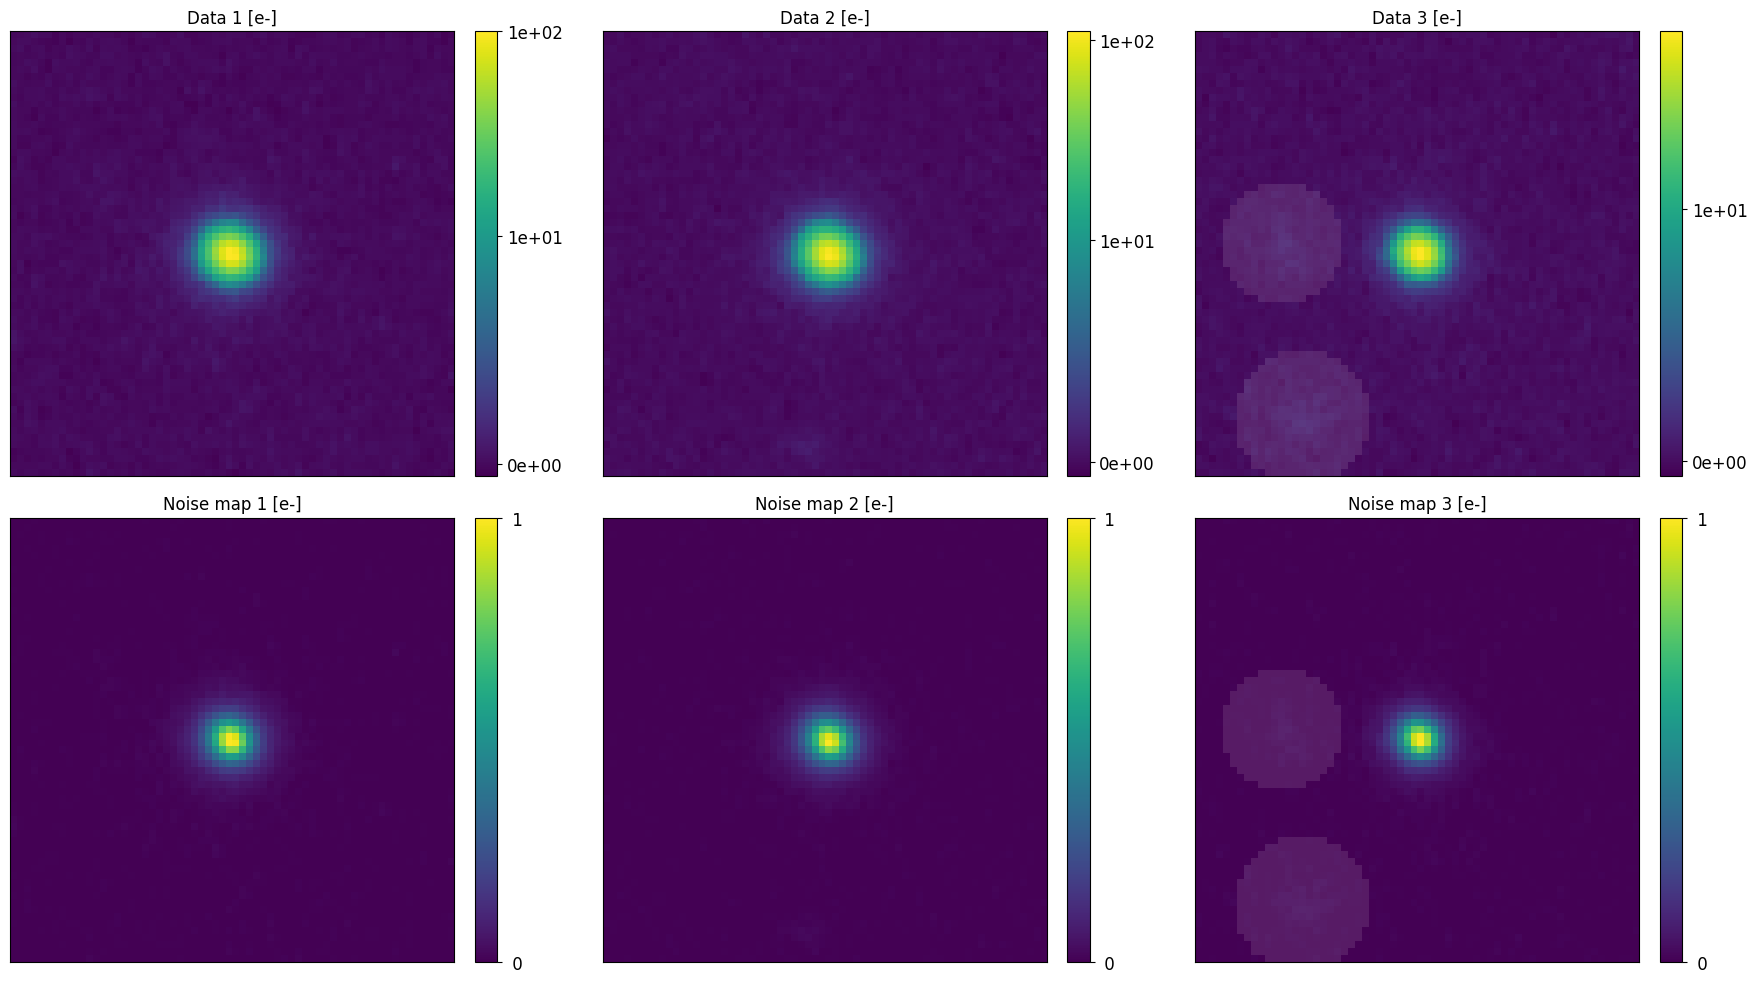

In [6]:
fig = pltf.display_data(new_vignets_data, sigma_2=sigma_2, masks=masks, units='e-')

### Creating STARRED instance
The next cells create the `PSF` and the `ParametersPSF` instance. First, we fix the background $h(x)$ and fit only a Moffat function. The code will also provide a first guess of the model parameters.

In [7]:
# Build the PSF model class
model = PSF(image_size=image_size, number_of_sources=N, 
            upsampling_factor=subsampling_factor, 
            convolution_method=convolution_method,
            include_moffat=include_moffat,
            elliptical_moffat=elliptical)

# Parameter initialization. 
kwargs_init, kwargs_fixed, kwargs_up, kwargs_down = model.smart_guess(new_vignets_data, masks=masks, fixed_background=True)

print('Initial Guess :', kwargs_init) 

parameters = ParametersPSF(kwargs_init, kwargs_fixed, kwargs_up=kwargs_up, kwargs_down=kwargs_down)

Initial Guess : {'kwargs_moffat': {'fwhm_x': 3.0, 'fwhm_y': 3.0, 'phi': 0.0, 'beta': 2.0, 'C': 154.50189208984375}, 'kwargs_gaussian': {'a': Array([172.89279, 183.13667, 107.47622], dtype=float32), 'x0': array([-0.37555737,  0.54317673, -0.37422037]), 'y0': array([-0.36676003, -0.5847007 , -1.02978475])}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}}


### Optimisation 
We then create the `Loss` instance that will be maximised. We then run the Moffat fit.

In [8]:
# Moffat fitting and amplitude tunning 
loss = Loss(new_vignets_data, model, parameters, sigma_2, N, regularization_terms='l1_starlet', 
            regularization_strength_scales=0, regularization_strength_hf=0, masks = masks) 
optim = Optimizer(loss, parameters, method=optim_method)

optimiser_options = {'maxiter':2000, 
                     'restart_from_init':True}

best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(**optimiser_options)

/Users/martin/Desktop/modules/starred/starred/optim/optimization.py:78: UserWarning: You are using an unconstrained optimiser. Bounds are ignored.
  warnings.warn('You are using an unconstrained optimiser. Bounds are ignored.')


### Showing the result of the Moffat fit

Moffat fit : {'kwargs_moffat': {'fwhm_x': Array([3.8528044], dtype=float32), 'fwhm_y': Array([3.5063226], dtype=float32), 'phi': Array([-0.46466646], dtype=float32), 'beta': Array([2.186454], dtype=float32), 'C': Array([154.47295], dtype=float32)}, 'kwargs_gaussian': {'a': Array([123.28694, 130.10034,  73.76669], dtype=float32), 'x0': Array([-0.2540066 ,  0.53030646,  0.324328  ], dtype=float32), 'y0': Array([-0.03557762, -0.1201364 ,  0.05976896], dtype=float32)}, 'kwargs_background': {'background': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}}


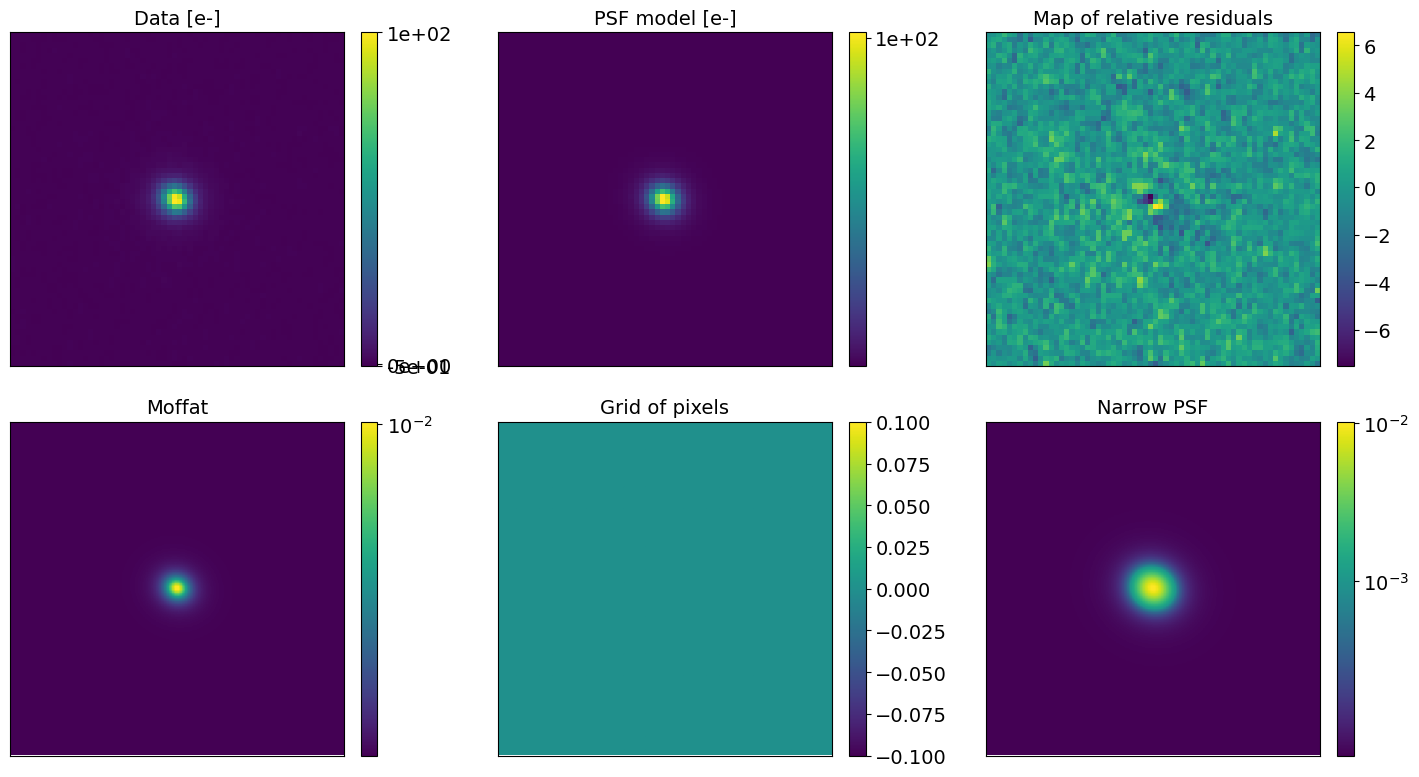

In [9]:
# Printing partial results
kwargs_partial = parameters.args2kwargs(best_fit)
print('Moffat fit :',kwargs_partial) 

fig2 = pltf.single_PSF_plot(model, new_vignets_data, sigma_2, kwargs_partial, n_psf=0, units='e-')

### Estimating noise levels in starlet space

From this rough estimation of the PSF, we can propagate the noise into starlet space and refine the reconstruction. The next cell shows a representation of the noise (background + Poisson noise) in each of the starlet scales. 

/Users/martin/Desktop/modules/starred/starred/utils/noise_utils.py:52: RuntimeWarning: Mean of empty slice
  noise_map = np.nanmean(centered_masked_noise_maps, axis=0)


1.7766931
1.3888044
0.7976176
0.40916067
0.19964698
0.09416453
0.04155595
0.018484913


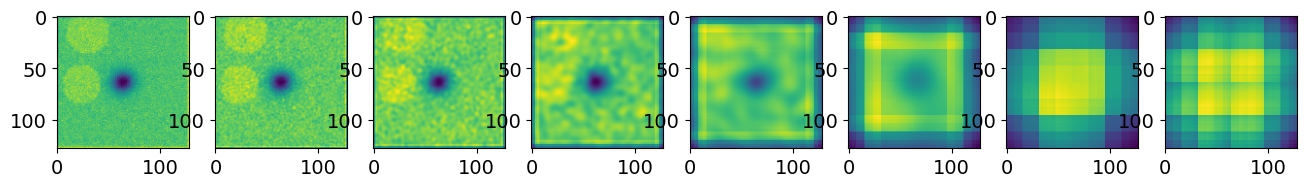

In [10]:
# compute noise level in starlet space, also propagate poisson noise
W = propagate_noise(model, np.sqrt(sigma_2), kwargs_partial, masks = masks, wavelet_type_list=['starlet'], method=method_noise, num_samples=500,
             seed=1, likelihood_type='chi2', verbose=False, upsampling_factor=subsampling_factor)[0]

#This is a representation of your noise level (background + Poisson) in the different starlet scales
gix, axs = plt.subplots(1, len(W), figsize=(16, 4))
for i, l in enumerate(W):
    axs[i].imshow(l)
    print(np.mean(l))
plt.show()
# You can save these noise maps to avoid recomputation
#np.save('./input/W_SLIT_chi2.npy', W)

## Create the final model 
Now, we will adjust the pixelated background $h(x)$. We first need to fix the Moffat amplitude to lift the degeneracy with the background. We also need to create a new `ParameterPSF` and `Loss` instance, because the number of free parameters has changed and those class needs to be recompiled to benefit for the JAX acceleration.

In [11]:
# Release backgound, fix the moffat amplitude
kwargs_moffat_fixed = {'C':kwargs_partial['kwargs_moffat']['C']}

kwargs_fixed = {
    'kwargs_moffat': kwargs_moffat_fixed,
    'kwargs_gaussian': {},
    'kwargs_background': {},
    'kwargs_distortion': kwargs_partial['kwargs_distortion']
}

parameters = ParametersPSF(kwargs_partial, kwargs_fixed, kwargs_up, kwargs_down)

loss = Loss(new_vignets_data, model, parameters, sigma_2, N, regularization_terms='l1_starlet',
            regularization_strength_scales=lambda_scales, regularization_strength_hf=lambda_hf,
            regularization_strength_positivity=lambda_positivity, W=W, regularize_full_psf=regularize_full_psf, masks=masks)


optim = Optimizer(loss, parameters, method='adabelief')

best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(max_iterations=600)

optax.adabelief: 100%|██████████| 600/600 [00:48<00:00, 12.29it/s]


{'kwargs_moffat': {'fwhm_x': Array([3.8920755], dtype=float32), 'fwhm_y': Array([3.5349302], dtype=float32), 'phi': Array([-0.49015185], dtype=float32), 'beta': Array([2.2079635], dtype=float32), 'C': Array([154.47295], dtype=float32)}, 'kwargs_gaussian': {'a': Array([121.66833, 128.1099 ,  72.61985], dtype=float32), 'x0': Array([-0.25383222,  0.53084564,  0.32039213], dtype=float32), 'y0': Array([-0.03515875, -0.11998154,  0.06304464], dtype=float32)}, 'kwargs_background': {'background': Array([-0.00023435,  0.00047167, -0.00178498, ..., -0.01731743,
       -0.01538973, -0.00760626], dtype=float32)}}


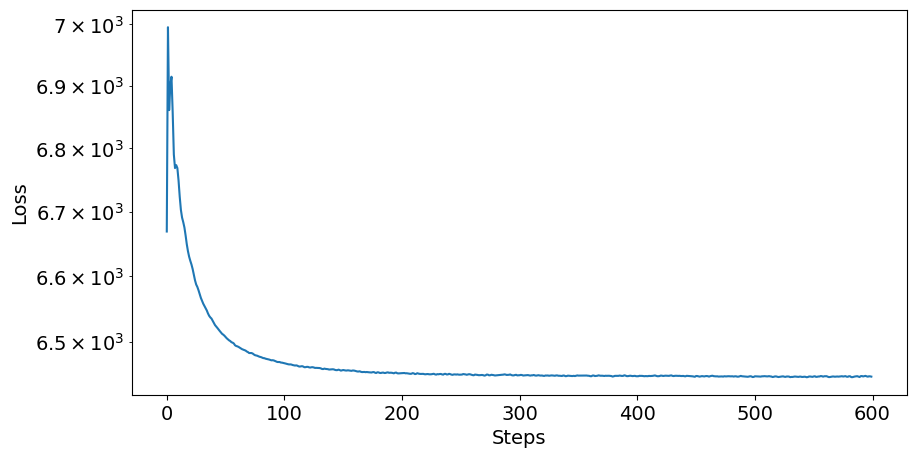

In [12]:
fig_loss = pltf.plot_loss(extra_fields['loss_history'])

kwargs_final = parameters.args2kwargs(best_fit)
print(kwargs_final)

## Retrieve the different componenet of the model
 - `s` is the reconstructed "narrow" PSF, $s(x) = m(x) + h(x)$
 - `analytic` is the Moffat component, $m(x)$
 - `background` corresponds to the pixelated correction, $h(x)$
 - `full_psf` is the PSF of the original image, $t(x)$
 - `estimated_full_psf0` is the best fit PSF model for star 0.


In [13]:
# Example on how to retrieve different elements of the PSF 
n_psf = 0
estimated_full_psf0 = model.model(**kwargs_final)[0]
analytic = model.get_moffat(kwargs_final['kwargs_moffat'], norm=True)
s = model.get_narrow_psf(**kwargs_final, norm=True)
background = model.get_background(kwargs_final['kwargs_background'])

full_psf = model.get_full_psf(**kwargs_final)

print('Overall Reduced Chi2 : ', loss.reduced_chi2(kwargs_final))

Overall Reduced Chi2 :  0.96195793


## Plotting the results

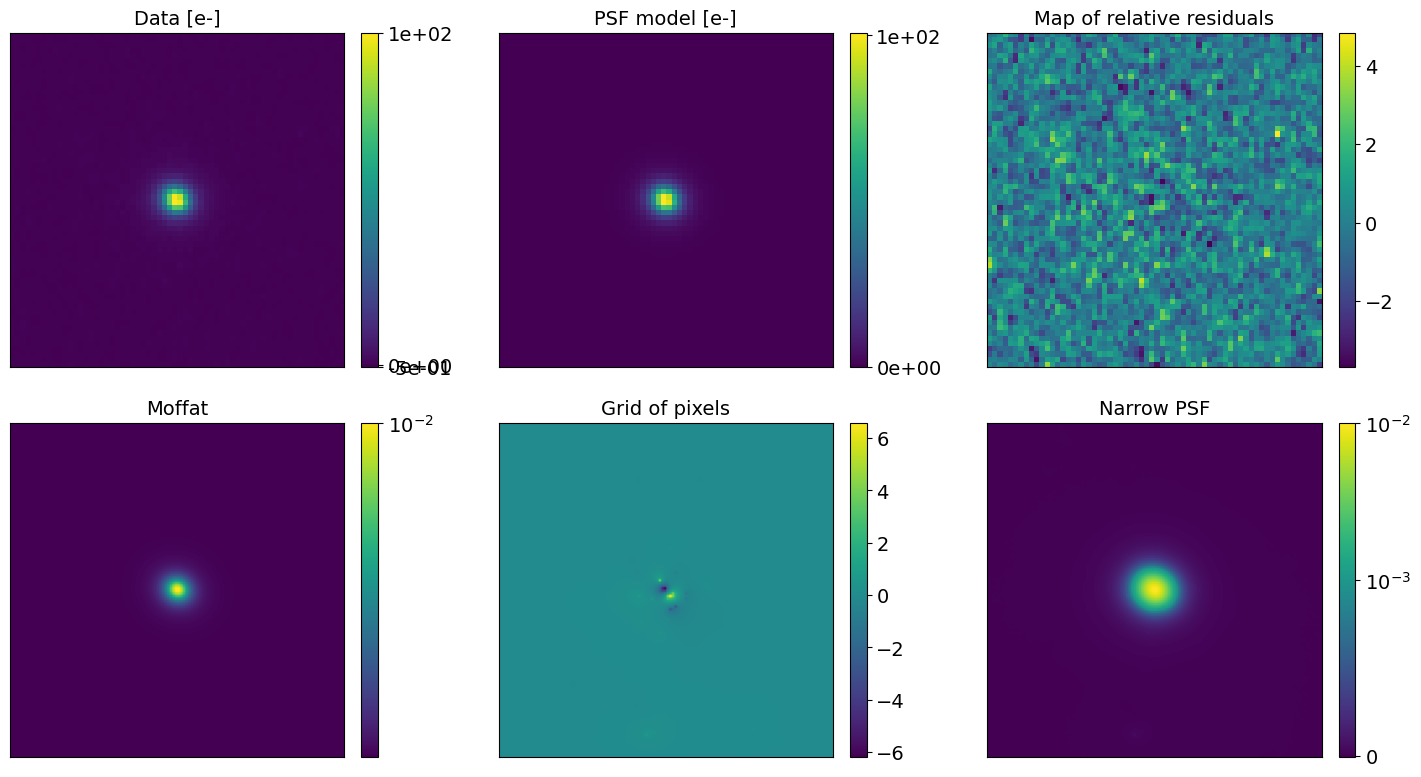

In [14]:
fig2 = pltf.single_PSF_plot(model, new_vignets_data, sigma_2, kwargs_final, n_psf=0, units='e-')

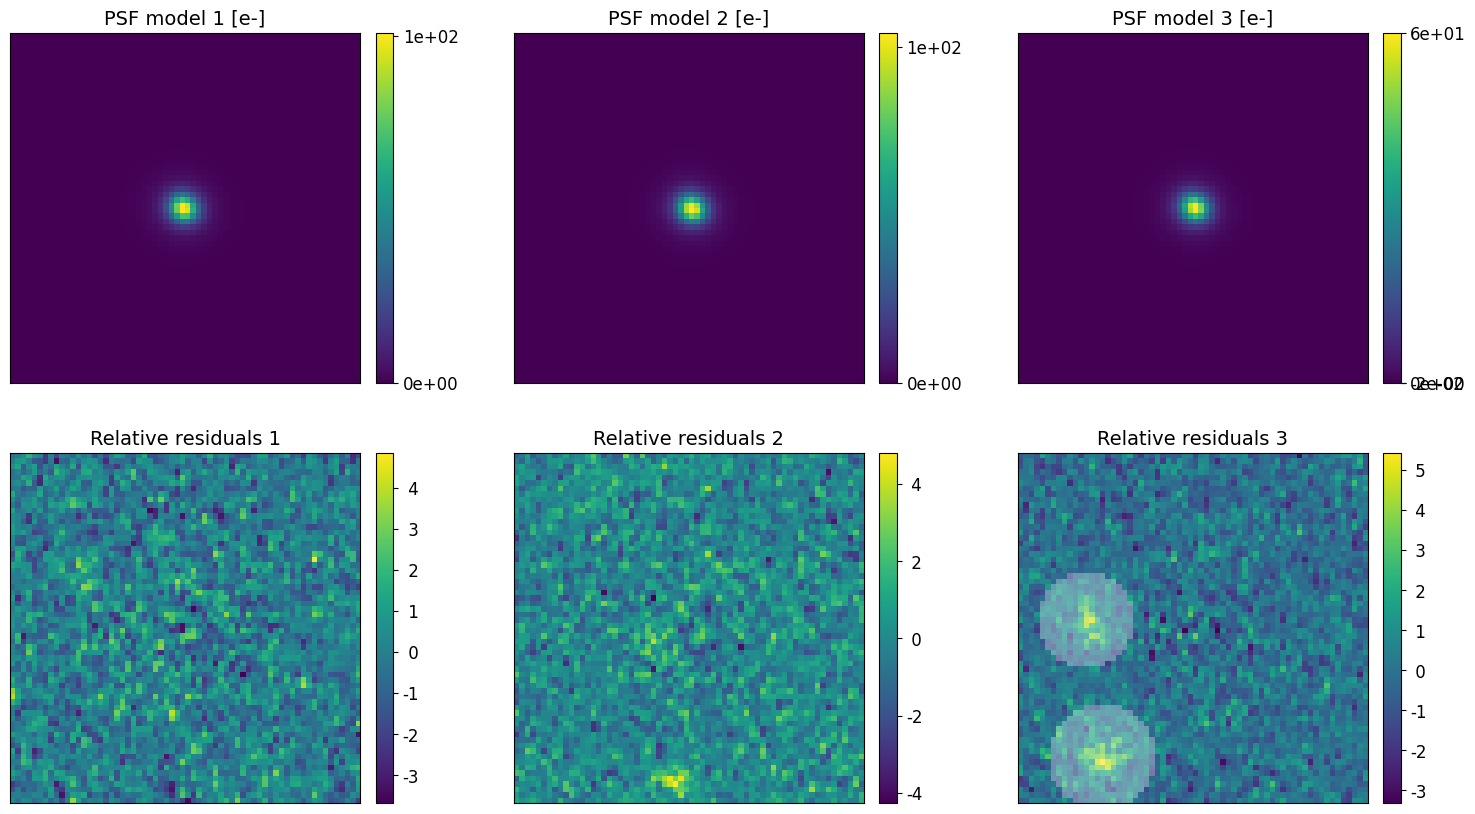

In [15]:
fig3 = pltf.multiple_PSF_plot(model, new_vignets_data, sigma_2, kwargs_final, masks=masks, units='e-')

### Retrieving point sources astrometry and photometry

In [16]:
astrometry = model.get_astrometry(**kwargs_final)
photometry = model.get_photometry(**kwargs_final) * norm 
photometry_highres = model.get_photometry(**kwargs_final, high_res=True) * norm / subsampling_factor**2 # photometry on the subsampled PSF

print('Astrometry :', np.asarray(astrometry))
print('Photometry :', np.asarray(photometry))
print('Photometry high resolution :', np.asarray(photometry_highres))

Astrometry : [[-0.25383222 -0.03515875]
 [ 0.53084564 -0.11998154]
 [ 0.32039213  0.06304464]]
Photometry : [662787.75 697868.06 395600.25]
Photometry high resolution : [662787.7  697868.1  395600.22]


### Export the model

In [17]:
output_folder = 'output/'

# Uncomment the following lines to save the obtained narrow PSF as a fits file
#model.export(output_folder, kwargs_final, new_vignets_data, sigma_2, format='fits')

# Generate better noise maps from the model (Optional)

From the reconstructed PSF, we now have a better model to estimate the Poisson noise. You can rerun this notebook, using the updated noise maps. The difference should be very minor if the SNR is sufficient. This can however make a small difference at low SNR.

__Warning__ : This can be done only if all your pixels have the same exposure time!

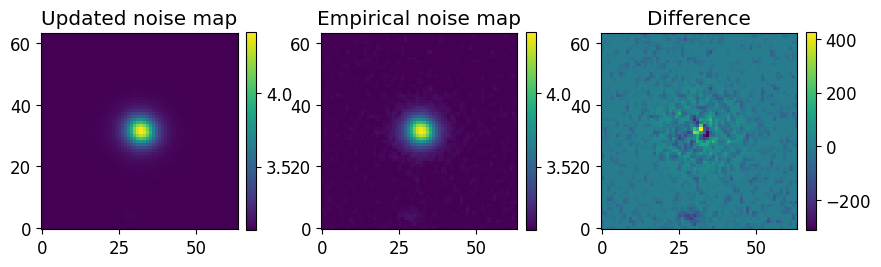

In [18]:
if refine_noise_maps_from_model: 
    updated_sigma2 = np.zeros_like(sigma_2)
    all_full_psf_model = model.model(**kwargs_final) * norm
    for i in range(N): 
        full_psf_model = all_full_psf_model[i]
        updated_sigma2[i] = sigma_sky_2[i] + full_psf_model.clip(min=0)
        assert np.all(updated_sigma2[i] > 0 )

        #save as fits files
        # hdu = fits.PrimaryHDU(updated_sigma2[i])
        # hdu.writeto(os.path.join(output_folder, 'updated_sigma2_%i.fits'%i), overwrite=True)

        # hdu = fits.PrimaryHDU(sigma_2[i] * norm**2)
        # hdu.writeto(os.path.join(output_folder, 'sigma2_%i.fits'%i), overwrite=True)

    n_psf = 1
    fraction = 0.046
    pad = 0.04
    fig, ax = plt.subplots(1,3, figsize=(10,6))   
    plt.subplots_adjust(wspace=0.3)   
    fig.colorbar(ax[0].imshow(np.log10(updated_sigma2[n_psf]),origin='lower'), fraction=fraction, pad=pad)
    ax[0].set_title('Updated noise map')
    ax[1].set_title('Empirical noise map')
    ax[2].set_title('Difference')
    fig.colorbar(ax[1].imshow(np.log10(sigma_2[n_psf] * norm**2),origin='lower'), fraction=fraction, pad=pad)
    fig.colorbar(ax[2].imshow(updated_sigma2[n_psf] - sigma_2[n_psf]* norm**2,origin='lower'), fraction=fraction, pad=pad)

1.7837822
1.3943367
0.8007864
0.41078234
0.20042999
0.09453417
0.04171416
0.018551072


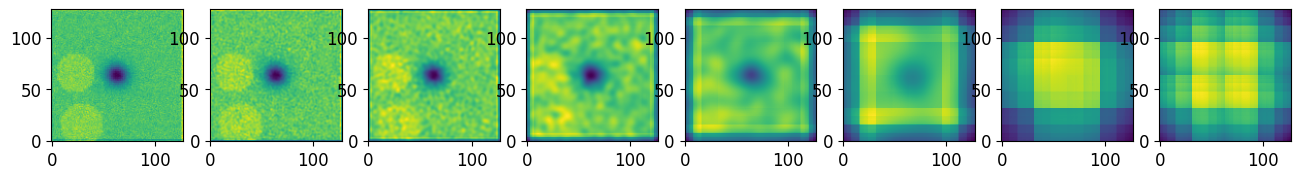

In [19]:
# Recompute noise propagation for the best model
if refine_noise_maps_from_model: 
    updated_sigma2 = updated_sigma2 / norm**2

    # compute noise level in starlet space, also propagate poisson noise
    W2 = propagate_noise(model, np.sqrt(updated_sigma2), kwargs_final, masks=masks, wavelet_type_list=['starlet'], method=method_noise, num_samples=500,
                seed=1, likelihood_type='chi2', verbose=False, upsampling_factor=subsampling_factor, scaling_noise_ref = None)[0]

    #This is a representation of your noise level (background + Poisson) in the different starlet scales
    gix, axs = plt.subplots(1, len(W2), figsize=(16, 4))
    for i, l in enumerate(W2):
        axs[i].imshow(l, origin='lower')
        print(np.mean(l))
    plt.show()

In [20]:
# Rerun the fit one more time with updated noise maps 
if refine_noise_maps_from_model: 
    parameters2 = ParametersPSF(deepcopy(kwargs_final), deepcopy(kwargs_fixed), deepcopy(kwargs_up), deepcopy(kwargs_down))

    loss2 = Loss(new_vignets_data, model, parameters2, updated_sigma2, N, regularization_terms='l1_starlet',
                regularization_strength_scales=lambda_scales, regularization_strength_hf=lambda_hf,
                regularization_strength_positivity=lambda_positivity, W=W2, regularize_full_psf=regularize_full_psf, masks=masks)


    optim2 = Optimizer(loss2, parameters2, method='adabelief')
   
    best_fit2, logL_best_fit2, extra_fields2, runtime2 = optim2.minimize(max_iterations=300,init_learning_rate=1e-3)

    kwargs_final2 = parameters2.args2kwargs(best_fit2)
    full_psf2 = model.get_full_psf(**kwargs_final2)

optax.adabelief: 100%|██████████| 300/300 [00:28<00:00, 10.35it/s]


/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_66399/3946708475.py:9: RuntimeWarning: invalid value encountered in log10
  ax[0].imshow(np.log10(full_psf),origin='lower')
/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_66399/3946708475.py:11: RuntimeWarning: invalid value encountered in log10
  ax[1].imshow(np.log10(full_psf2), origin='lower')


{'kwargs_moffat': {'fwhm_x': Array([3.8892195], dtype=float32), 'fwhm_y': Array([3.5328557], dtype=float32), 'phi': Array([-0.49015638], dtype=float32), 'beta': Array([2.1998994], dtype=float32), 'C': Array([154.47295], dtype=float32)}, 'kwargs_gaussian': {'a': Array([121.76559 , 128.20642 ,  72.686035], dtype=float32), 'x0': Array([-0.25392258,  0.53070813,  0.32023647], dtype=float32), 'y0': Array([-0.03511881, -0.12000106,  0.06308421], dtype=float32)}, 'kwargs_background': {'background': Array([ 1.2703874e-06, -3.2115908e-04, -1.7152022e-04, ...,
       -9.9726385e-03, -8.3799139e-03, -4.0456988e-03], dtype=float32)}}


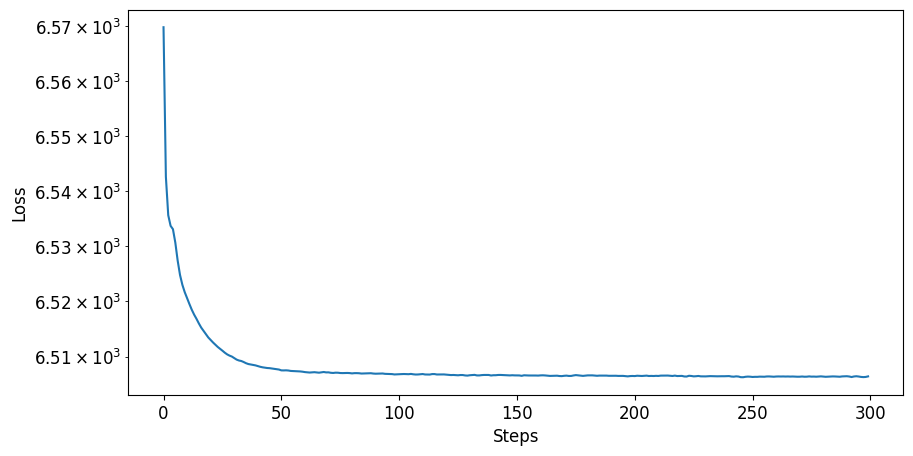

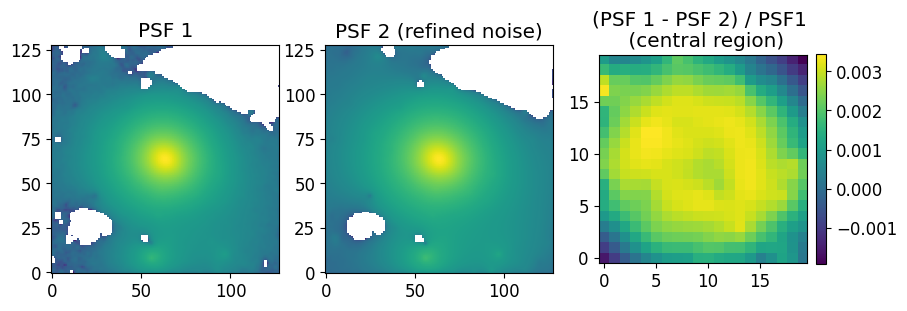

In [21]:
#Loss plot 
if refine_noise_maps_from_model:
    fig_loss2 = pltf.plot_loss(extra_fields2['loss_history'])

    #PSF difference after the second iteration

    m = 10 #size of the inner region of the PSF to plot
    fig6, ax = plt.subplots(1,3, figsize = (10,5))
    ax[0].imshow(np.log10(full_psf),origin='lower')
    ax[0].set_title('PSF 1')
    ax[1].imshow(np.log10(full_psf2), origin='lower')
    ax[1].set_title('PSF 2 (refined noise)')
    ax[2].set_title('(PSF 1 - PSF 2) / PSF1 \n (central region)')
    fig.colorbar(ax[2].imshow((full_psf[int(image_size_up/2) - m : int(image_size_up/2) +m, int(image_size_up/2) - m : int(image_size_up/2) +m] - 
                            full_psf2[int(image_size_up/2) - m : int(image_size_up/2) +m, int(image_size_up/2) - m : int(image_size_up/2) +m])/ 
                            full_psf[int(image_size_up/2) - m : int(image_size_up/2) +m, int(image_size_up/2) - m : int(image_size_up/2) +m] 
                            , origin='lower'), ax=ax[2], fraction=0.046, pad=0.04)

    print(kwargs_final2)

Overall Reduced Chi2 :  0.96195793
Mean background level: -0.035964414
Std background level [in unit of noise level]: 1.0737818


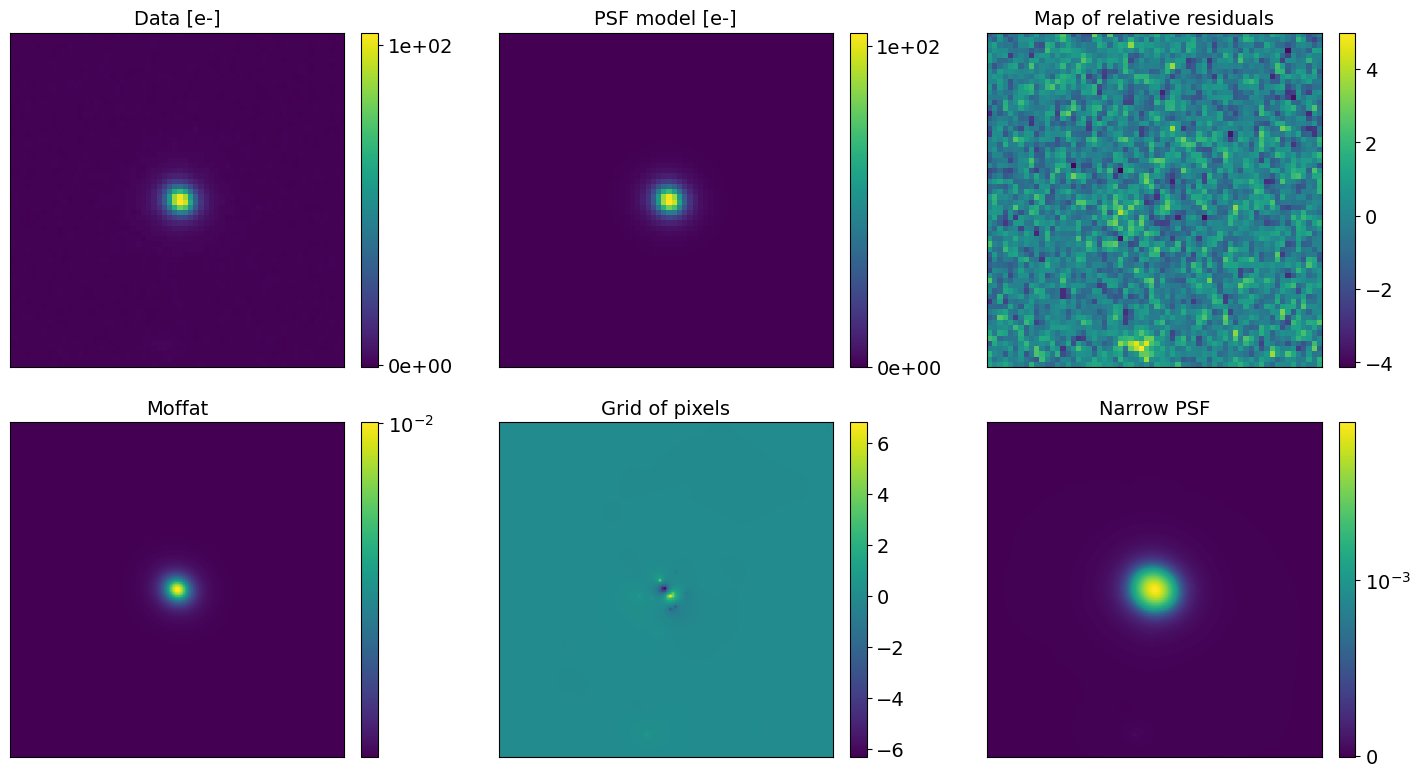

In [22]:
if refine_noise_maps_from_model: 
    fig7 = pltf.single_PSF_plot(model, new_vignets_data, updated_sigma2, kwargs_final2, n_psf=1, units='e-')
    fig8 = pltf.multiple_PSF_plot(model, new_vignets_data, updated_sigma2, kwargs_final2, masks=masks, units='e-', vmin=-5, vmax=5)

    print('Overall Reduced Chi2 : ', loss.reduced_chi2(kwargs_final))
    
    n_psf = 0
    estimated_full_psf0 = model.model(**kwargs_final2)[n_psf]
    dif = new_vignets_data[n_psf,:,:] - estimated_full_psf0
    rr = dif / np.sqrt(sigma_2[n_psf,:,:])

    print('Mean background level:', np.mean(rr))
    print('Std background level [in unit of noise level]:',np.std(rr))

# Exporting the model as hdf5
Data products can be exported as a hdf5 file by uncommenting the following lines:

In [23]:
# import h5py
# if refine_noise_maps_from_model:
    # outpath_refined = os.path.join(output_folder, 'updated_noise_%i'%subsampling_factor)
    # if not os.path.isdir(outpath_refined):
        # os.mkdir(outpath_refined)
    
    #save the fits images
    # model.export(outpath_refined, kwargs_final2, new_vignets_data, updated_sigma2, format='fits')

    # Save and Recover you model form the saved hdf5 file:
    # hdf5_output=os.path.join(outpath_refined, 'model.hdf5')
    # model.dump(hdf5_output, kwargs_final2, norm, data=new_vignets_data, sigma_2=updated_sigma2, masks=masks, save_output_level=4, format='hdf5')
    # model_rec, kwargs_final2_rec, norm_rec, data_rec, sigma_2_rec, masks_rec = load_PSF_model(hdf5_output, format='hdf5')

    #to list all the keyword entries of the hdf5 file: 
    # with h5py.File(hdf5_output, 'r') as f: 
    #     print(f.keys())
